In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from trainer import *
from results import Results
set_seaborn()
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150


In [13]:
import scipy
import numpy as np
from tools import *


def build_train_test_hankels(X, Y, dim, test_start, train_test_ratio):

    start = int(len(X) * test_start)
    end = start + int(len(X) * train_test_ratio)

    X_test, Y_test = X[start:end],  Y[start:end]
    X_train, Y_train = X.copy(), Y.copy()

    # use to remove from hankel later
    X_train[start:end] = np.nan

    # remove the beginning for causal convoltuion
    Y_train = np.delete(Y_train, np.arange(0, dim))
    Y_test = np.delete(Y_test, np.arange(0, dim))

    test_hankel = build_hankel(X_test, dim)
    train_hankel = build_hankel(X_train, dim)

    # remove lag vector with nan
    nan_cols = np.bitwise_or.reduce(np.isnan(train_hankel), 0)

    train_hankel = np.delete(train_hankel, nan_cols, axis=1)
    Y_train = np.delete(Y_train, nan_cols)

    return train_hankel, Y_train, test_hankel, Y_test


def train_test_method(X, Y, model, dims, train_test_ratio=0.2, beta=1e-8):

    test_start_range = np.linspace(0.0, 1.0-train_test_ratio, 100)
    T = len(test_start_range)
    B = len(dims)

    train_errors = np.zeros((B, T))
    test_errors = np.zeros((B, T))
    filters = np.zeros((B, T), dtype='O')
    all_params = np.zeros((B, T), dtype='O')
    for b, dim in enumerate(dims):
        for t, test_start in enumerate(test_start_range):

            train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(
                X, Y, dim, test_start, train_test_ratio)
            
            P_train, theta, params = model.train(
                train_hankel, Y_train, dim, beta=beta)
            P_test = model.test(test_hankel, theta, params)
            train_err = mean_square_error(Y_train, P_train)
            test_err = mean_square_error(Y_test, P_test)

            train_errors[b, t] = train_err
            test_errors[b, t] = test_err
            filters[b, t] = theta
            all_params[b, t] = params

    return train_errors, test_errors, filters, all_params, dims


In [14]:

# downsample
def downsample(signal, factor=1):
    # take mean of all trials
    mean = np.mean(signal, axis=0)
    # down samples mean of trials
    n = len(mean) // factor
    down = []
    for i in range(0, len(mean), factor):
        m = np.mean(mean[i:i+factor])
        down.append(m)
    down = np.array(down)
    return down


In [15]:
resPH, _ = read_lmc('PHOTO')
res1, _ = read_lmc('LMC-BG1')

dt_ms = 2.0
lags = [20, 30,  40,  50,  60, 70, 80]
dims = []
for l in lags:
    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, l)
    dims.append(dim)

X = downsample(resPH, factor=factor)
Y = downsample(res1, factor=factor)

all_results = []

model = ConstantModel(f'Identity')
res = train_test_method(X, Y, model, np.ones_like(dims))
C2_Results = Results(model.name, *res)

model = LinearModel(f'Optimal Linear')
res = train_test_method(X, Y, model, dims, beta=0)
Lin50_Results = Results(model.name, *res)

model = EigenTimeModel(f'Eigen-Window')
res = train_test_method(X, Y, model, dims)
EigTime_Results = Results(model.name, *res)

# model = EigenCShiftTimeModel(
#     f'Eigen-CShift-Time {title}', window_factor=2.0)
# res = train_test_method(X, Y, model, dims)
# EigenCShiftTime_Results = Results(model.name, *res)

cur_results = [C2_Results, Lin50_Results, EigTime_Results]


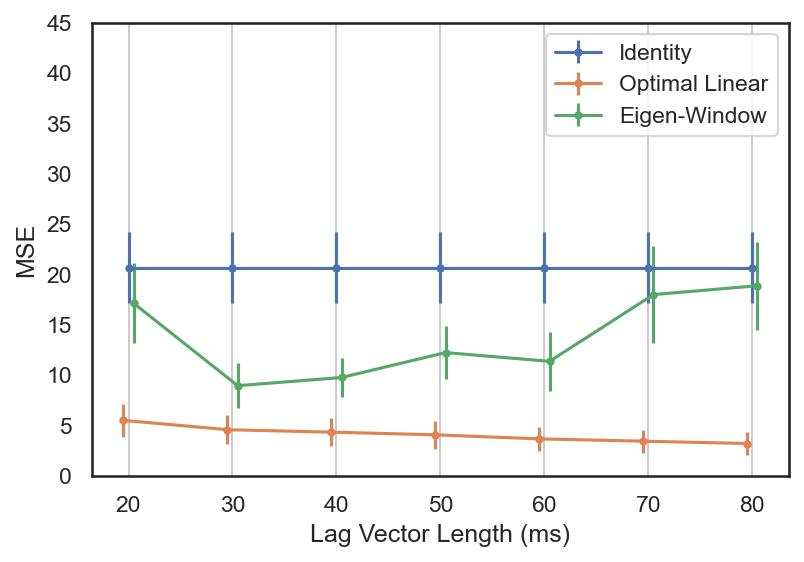

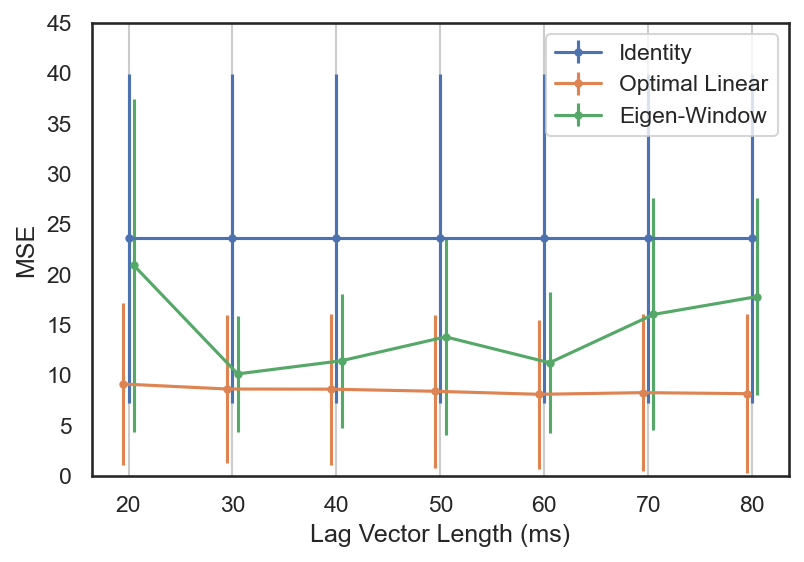

In [21]:
from matplotlib.transforms import Affine2D

ylims = [0, 45]
fig, ax = plt.subplots()
shift = [0, -0.5, 0.5]
for i, result in enumerate(cur_results):
    (err, std), l = result.get_train_errs(), result.name
    trans1 = Affine2D().translate(shift[i], 0.0) + ax.transData
    ax.errorbar(lags, err, yerr=std, label=l,  marker='.', transform=trans1)

plt.ylim(ylims)
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Lag Vector Length (ms)')
plt.xticks(lags)
plt.grid(axis='x')
plt.show()


fig, ax = plt.subplots()
for i, result in enumerate(cur_results):
    (err, std), l = result.get_test_errs(), result.name
    trans1 = Affine2D().translate(shift[i], 0.0) + ax.transData
    ax.errorbar(lags, err, yerr=std, label=l, marker='.', transform=trans1)

plt.ylim(ylims)
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Lag Vector Length (ms)')
plt.xticks(lags)
plt.grid(axis='x')
plt.show()

# plot_filter(*Lin50_Results.get_opt_filter(opt_set='train'), title=f'Linear Filter')
# plot_filter(*EigTime_Results.get_opt_filter(opt_set='train'), title=f'Eigen-Window Filter')


In [17]:
resPH, _ = read_lmc('PHOTO')
res1, _ = read_lmc('LMC-BG1')

dt_ms = 2.0
lag = 30
dims = []

factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag)


X = downsample(resPH, factor=factor)
Y = downsample(res1, factor=factor)
time = np.linspace(0,1,len(X))

train_test_ratio= 0.2
test_start = 0.8
start = int(len(X) * test_start)
end = start + int(len(X) * train_test_ratio)

time_train, time_test = time[:start], time[start:end]
X_test, Y_test = X[start:end],  Y[start:end]
X_train, Y_train = X[:start], Y[:start]


model = EigenTimeModel(f'Eigen-Window')
trainHan = build_hankel(X_train, dim)
testHan = build_hankel(X_test, dim)
train_pred, theta, (a, b) = model.train(trainHan, Y_train[dim:], dim)
test_pred = model.test(testHan, theta, (a, b))
theta /= theta[-1]


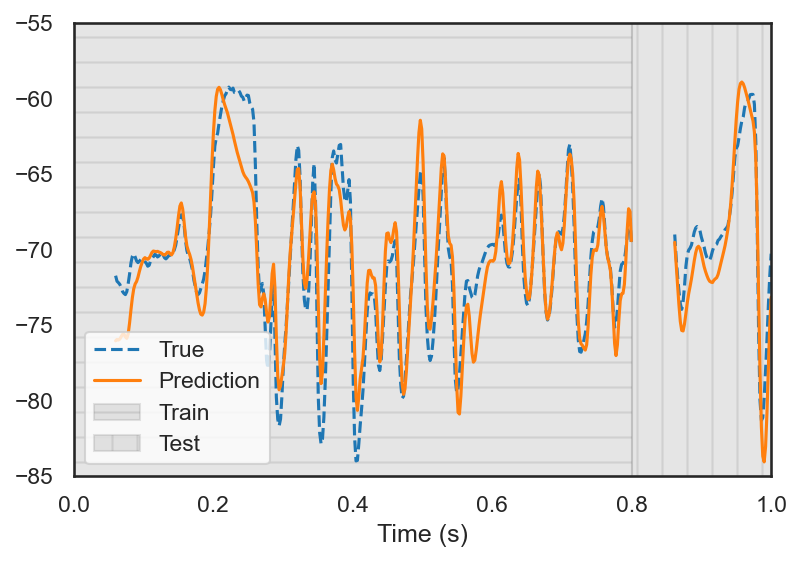

In [39]:
sns.set_style('white')
plt.plot(time_train[dim:], Y_train[dim:], '--',  label='True', color='tab:blue')
plt.plot(time_train[dim:], train_pred, label='Prediction', color='tab:orange')

plt.plot(time_test[dim:], Y_test[dim:],'--', color='tab:blue')
plt.plot(time_test[dim:], test_pred, color='tab:orange')

plt.fill_between(np.arange(-1,0.9,0.1), -100, 100, alpha=0.2, label='Train', color='grey', hatch='-')
plt.fill_between(np.arange(0.8,2,0.1), -100, 100, alpha=0.2, label='Test', color='grey', hatch='|')
plt.ylim([-85,-55])
plt.xlim([0,1])
plt.legend()
plt.xlabel('Time (s)')
plt.show()

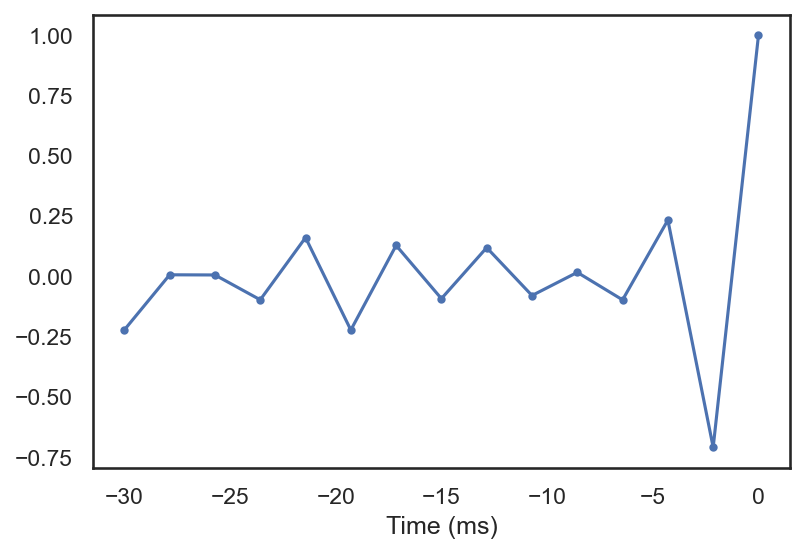

In [19]:
theta_time = np.linspace(-lag, 0, len(theta))
plt.xlabel('Time (ms)')
plt.plot(theta_time, theta, '.-')
plt.show()


30


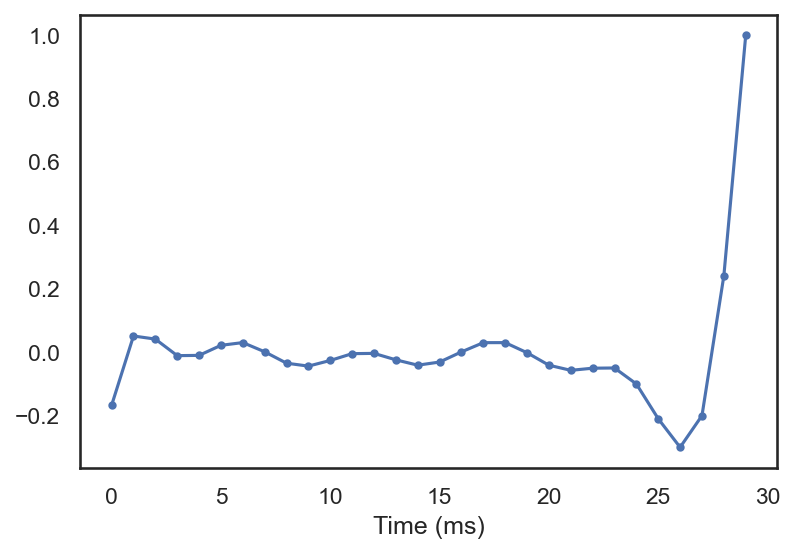

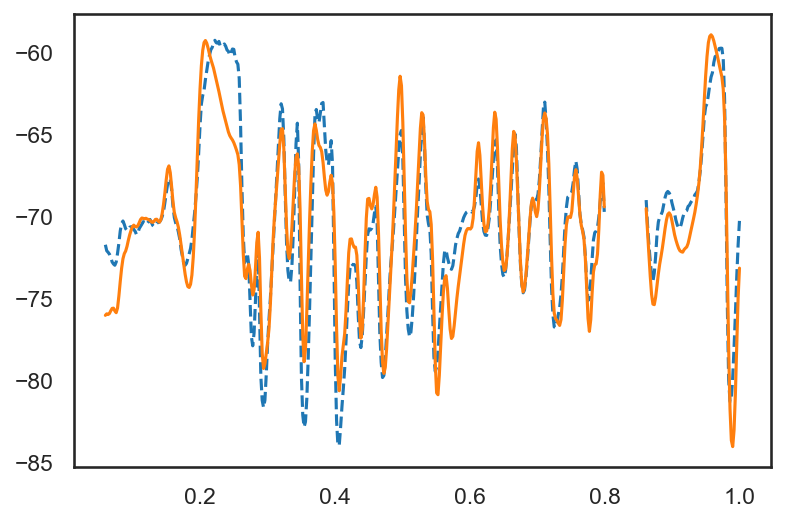

4.611737368232574


In [20]:
lag = 60

factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag)
trainHan = build_hankel(X_train, dim)
testHan = build_hankel(X_test, dim)


print(dim)
# model = LinearModel(f'Linear')
# train_pred, theta, b = model.train(trainHan, Y_train[dim:], dim, beta=30)
# test_pred = model.test(testHan, theta, b)
# theta /= theta[-1]
# plt.plot(theta, '.-')
# theta_time = np.linspace(-lag, 0, len(theta))
# plt.xlabel('Time (ms)')
# plt.show()

# plt.plot(time_train[dim:], Y_train[dim:], '--',  label='True', color='tab:blue')
# plt.plot(time_train[dim:], train_pred, label='Prediction', color='tab:orange')
# plt.plot(time_test[dim:], Y_test[dim:],'--', color='tab:blue')
# plt.plot(time_test[dim:], test_pred, color='tab:orange')
# plt.show()
# print(mean_square_error(Y_train[dim:], train_pred))

model = LinearModel(f'Linear')
train_pred, theta, b = model.train(trainHan, Y_train[dim:], dim, beta=100)
test_pred = model.test(testHan, theta, b)
theta /= theta[-1]
plt.plot(theta, '.-')
theta_time = np.linspace(-lag, 0, len(theta))
plt.xlabel('Time (ms)')
plt.show()

plt.plot(time_train[dim:], Y_train[dim:], '--',  label='True', color='tab:blue')
plt.plot(time_train[dim:], train_pred, label='Prediction', color='tab:orange')
plt.plot(time_test[dim:], Y_test[dim:],'--', color='tab:blue')
plt.plot(time_test[dim:], test_pred, color='tab:orange')
plt.show()
print(mean_square_error(Y_train[dim:], train_pred))
